In [1]:
# data manipulation libraries
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.model_selection import train_test_split

# pyspark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import types, functions as F

# random seed for reproducibility
RANDOM_SEED = 15

import shap
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from sklearn.model_selection import RepeatedKFold
plt.style.use('seaborn-white')

app_name = 'nat-geohash'
conf = (SparkConf()
        .setMaster("yarn-client")
        .setAppName(app_name)
        .set("spark.driver.maxResultSize", "10g")
        .set("spark.driver.memory", "16g")
        .set("spark.driver.memoryOverhead", "4096")
        .set("spark.dynamicAllocation.enabled", "true")
        .set("spark.dynamicAllocation.initialExecutors", "1")
        .set("spark.dynamicAllocation.maxExecutors", "75")
        .set("spark.dynamicAllocation.minExecutors", "1")
        .set("spark.executor.cores", "8")
        .set("spark.executor.memory", "40G")
        .set("spark.hadoop.fs.permissions.umask-mode", "002")
        .set("spark.kryoserializer.buffer.max", "512m")
        .set("spark.shuffle.service.enabled", "true")
        .set("spark.sql.broadcastTimeout", "1000")
        .set("spark.sql.hive.convertMetastoreParquet", "false")
        .set("spark.sql.parquet.compression.codec", "snappy")
        .set("spark.sql.shuffle.partitions", "1000")
        .set("spark.sql.sources.partitionOverwriteMode", "dynamic")
        .set("spark.yarn.driver.memoryOverhead", "4096")
        .set("spark.yarn.executor.memoryOverhead", "8G")
        .set("spark.yarn.maxAppAttempts", "2")
        .set("spark.yarn.queue", "root.hue_dmp")
        .set("yarn.nodemanager.vmem-check-enabled", "false")
        .set("hive.exec.dynamic.partition", "true")
        .set("hive.exec.dynamic.partition.mode", "nonstrict")
        .set("hive.exec.max.dynamic.partitions", "2048")
        )
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)
spark


Bad key backend.qt4 in file /etc/matplotlib/matplotlibrc, line 43 ('backend.qt4 : PyQt4        # PyQt4 | PySide')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df1 = spark.read.table('dbi.sample_site_for_outlet_v2')
df1 = df1.toPandas()
df1

,site_id,fea_min_distance_outlet_to_leisure_and_outdoor,fea_min_distance_outlet_to_areas_and_buildings,fea_min_distance_outlet_to_shopping,fea_min_distance_outlet_to_going_out_entertainment,fea_min_distance_outlet_to_sights_and_museums,fea_min_distance_outlet_to_facilities,fea_min_distance_outlet_to_accommodation,fea_min_distance_outlet_to_natural_and_geographical,fea_min_distance_outlet_to_business_and_services,...,class,kecamatan,kabupaten,region,availability,cei_rating,nei_rating,subs_total,subs_4g,bandwidth
0,DPR033,42.67,469.39,23.12,59.18,20.29,17.70,22.54,3024.48,20.68,...,Silver,DENPASAR BARAT,KOTA DENPASAR,BALI NUSRA,100.0,4.794011769285581,3.5331417551724136,510.0,176.0,150.0
1,BIM187,709.89,1148.85,66.48,8445.20,55.11,527.42,3192.16,7228.01,585.75,...,Silver,MADA PANGGA,BIMA,BALI NUSRA,100.0,4.1622469478348885,3.177586227586207,877.0,264.0,90.0
2,SMD390,3176.05,552.13,40.04,2238.89,117.56,37.10,2449.66,11302.95,45.67,...,Bronze,JATINUNGGAL,SUMEDANG,WEST JAVA,100.0,3.6876663502279943,3.2216092,485.0,80.0,30.0
3,SUB518,622.39,613.37,310.83,338.56,338.70,364.56,1004.12,0.00,295.08,...,Gold,PAMANUKAN,SUBANG,WEST JAVA,100.0,3.8152947400176815,3.3302873448275863,1600.0,614.0,90.0
4,BIR300,4511.92,380.06,442.76,1430.14,52.53,112.37,2216.73,0.00,399.68,...,Bronze,PEUDADA,BIREUEN,SUMBAGUT,100.0,3.8700627609551295,3.4436781551724143,531.0,107.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58418,SDA289,1169.69,99.02,123.87,34.72,121.74,82.80,139.54,14716.60,209.62,...,Gold,SIDOARJO,SIDOARJO,EAST JAVA,100.0,4.464815617099196,3.145114968965517,1684.0,720.0,120.0
58419,KRW169,1567.79,220.53,156.94,548.76,219.57,192.44,1252.18,4573.07,165.97,...,Gold,KOTABARU,KARAWANG,JABOTABEK,100.0,3.63344058576796,3.128390806896552,968.0,366.0,90.0
58420,BJO154,2537.36,67.91,45.58,894.98,201.59,105.43,697.29,6858.61,112.27,...,Silver,BAURENO,BOJONEGORO,EAST JAVA,100.0,3.906012601390159,3.088793120689655,852.0,215.0,90.0
58421,PBG002,643.64,335.26,60.33,524.21,48.52,41.76,375.57,4538.36,66.50,...,Silver,PURBALINGGA,PURBALINGGA,CENTRAL JAVA,100.0,4.045346686935628,3.252643703448276,1544.0,556.0,90.0


In [72]:
#Spark Reead : for Aggregation :

pd.options.display.max_columns = None
pd.options.display.max_rows = None

df_100m = spark.sql("""select 
                        b.kecamatan,
                        sum(b.subs_4g) as subs_4g,
                        sum(b.fea_outlet_under_100m_to_leisure_and_outdoor) fea_outlet_under_100m_to_leisure_and_outdoor,
                        sum(b.fea_outlet_under_100m_to_areas_and_buildings) fea_outlet_under_100m_to_areas_and_buildings,
                        sum(b.fea_outlet_under_100m_to_shopping) fea_outlet_under_100m_to_shopping,
                        sum(b.fea_outlet_under_100m_to_going_out_entertainment) fea_outlet_under_100m_to_going_out_entertainment,
                        sum(b.fea_outlet_under_100m_to_sights_and_museums) fea_outlet_under_100m_to_sights_and_museums,
                        sum(b.fea_outlet_under_100m_to_facilities) fea_outlet_under_100m_to_facilities,
                        sum(b.fea_outlet_under_100m_to_accommodation) fea_outlet_under_100m_to_accommodation,
                        sum(b.fea_outlet_under_100m_to_natural_and_geographical) fea_outlet_under_100m_to_natural_and_geographical,
                        sum(b.fea_outlet_under_100m_to_business_and_services) fea_outlet_under_100m_to_business_and_services,
                        sum(b.fea_outlet_under_100m_to_transport) fea_outlet_under_100m_to_transport,            
                        sum(b.fea_outlet_under_100m_to_eat_and_drink) fea_outlet_under_100m_to_eat_and_drink
                    from
                        dbi.sample_site_for_outlet_v2 b 
                    where 
                        b.subs_4g > 100
                     group by kecamatan
""").toPandas()
df_100m.head()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42768)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:42768)

In [3]:
df1.head()

,site_id,fea_min_distance_outlet_to_leisure_and_outdoor,fea_min_distance_outlet_to_areas_and_buildings,fea_min_distance_outlet_to_shopping,fea_min_distance_outlet_to_going_out_entertainment,fea_min_distance_outlet_to_sights_and_museums,fea_min_distance_outlet_to_facilities,fea_min_distance_outlet_to_accommodation,fea_min_distance_outlet_to_natural_and_geographical,fea_min_distance_outlet_to_business_and_services,...,class,kecamatan,kabupaten,region,availability,cei_rating,nei_rating,subs_total,subs_4g,bandwidth
0,DPR033,42.67,469.39,23.12,59.18,20.29,17.70,22.54,3024.48,20.68,...,Silver,DENPASAR BARAT,KOTA DENPASAR,BALI NUSRA,100.0,4.794011769285581,3.5331417551724136,510.0,176.0,150.0
1,BIM187,709.89,1148.85,66.48,8445.20,55.11,527.42,3192.16,7228.01,585.75,...,Silver,MADA PANGGA,BIMA,BALI NUSRA,100.0,4.1622469478348885,3.177586227586207,877.0,264.0,90.0
2,SMD390,3176.05,552.13,40.04,2238.89,117.56,37.10,2449.66,11302.95,45.67,...,Bronze,JATINUNGGAL,SUMEDANG,WEST JAVA,100.0,3.6876663502279943,3.2216092,485.0,80.0,30.0
3,SUB518,622.39,613.37,310.83,338.56,338.70,364.56,1004.12,0.00,295.08,...,Gold,PAMANUKAN,SUBANG,WEST JAVA,100.0,3.8152947400176815,3.3302873448275863,1600.0,614.0,90.0
4,BIR300,4511.92,380.06,442.76,1430.14,52.53,112.37,2216.73,0.00,399.68,...,Bronze,PEUDADA,BIREUEN,SUMBAGUT,100.0,3.8700627609551295,3.4436781551724143,531.0,107.0,30.0


In [4]:
df1.columns = ['site_id', 'min_distance_site_to_POI_to_leisure_and_outdoor',
       'min_distance_site_to_POI_to_areas_and_buildings',
       'min_distance_site_to_POI_to_shopping',
       'min_distance_site_to_POI_to_going_out_entertainment',
       'min_distance_site_to_POI_to_sights_and_museums',
       'min_distance_site_to_POI_to_facilities',
       'min_distance_site_to_POI_to_accommodation',
       'min_distance_site_to_POI_to_natural_and_geographical',
       'min_distance_site_to_POI_to_business_and_services',
       'min_distance_site_to_POI_to_transport',
       'min_distance_site_to_POI_to_eat_and_drink',
       'site_to_POI_under_100m_category_leisure_and_outdoor',
       'site_to_POI_under_250m_category_leisure_and_outdoor',
       'site_to_POI_under_500m_category_leisure_and_outdoor',
       'site_to_POI_under_1000m_category_leisure_and_outdoor',
       'site_to_POI_under_100m_category_areas_and_buildings',
       'site_to_POI_under_250m_category_areas_and_buildings',
       'site_to_POI_under_500m_category_areas_and_buildings',
       'site_to_POI_under_1000m_category_areas_and_buildings',
       'site_to_POI_under_100m_category_shopping',
       'site_to_POI_under_250m_category_shopping',
       'site_to_POI_under_500m_category_shopping',
       'site_to_POI_under_1000m_category_shopping',
       'site_to_POI_under_100m_category_going_out_entertainment',
       'site_to_POI_under_250m_category_going_out_entertainment',
       'site_to_POI_under_500m_category_going_out_entertainment',
       'site_to_POI_under_1000m_category_going_out_entertainment',
       'site_to_POI_under_100m_category_sights_and_museums',
       'site_to_POI_under_250m_category_sights_and_museums',
       'site_to_POI_under_500m_category_sights_and_museums',
       'site_to_POI_under_1000m_category_sights_and_museums',
       'site_to_POI_under_100m_category_facilities',
       'site_to_POI_under_250m_category_facilities',
       'site_to_POI_under_500m_category_facilities',
       'site_to_POI_under_1000m_category_facilities',
       'site_to_POI_under_100m_category_accommodation',
       'site_to_POI_under_250m_category_accommodation',
       'site_to_POI_under_500m_category_accommodation',
       'site_to_POI_under_1000m_category_accommodation',
       'site_to_POI_under_100m_category_natural_and_geographical',
       'site_to_POI_under_250m_category_natural_and_geographical',
       'site_to_POI_under_500m_category_natural_and_geographical',
       'site_to_POI_under_1000m_category_natural_and_geographical',
       'site_to_POI_under_100m_category_business_and_services',
       'site_to_POI_under_250m_category_business_and_services',
       'site_to_POI_under_500m_category_business_and_services',
       'site_to_POI_under_1000m_category_business_and_services',
       'site_to_POI_under_100m_category_transport',
       'site_to_POI_under_250m_category_transport',
       'site_to_POI_under_500m_category_transport',
       'site_to_POI_under_1000m_category_transport',
       'site_to_POI_under_100m_category_eat_and_drink',
       'site_to_POI_under_250m_category_eat_and_drink',
       'site_to_POI_under_500m_category_eat_and_drink',
       'site_to_POI_under_1000m_category_eat_and_drink', 'site_name', 'long', 'lat',
       'site_class', 'kecamatan', 'kabupaten', 'region', 'network_availability',
       'CEI_rating', 'NEI_rating', 'subs_total', 'subs_4g', 'network_resources']

In [5]:
df1.columns

Index(['site_id', 'min_distance_site_to_POI_to_leisure_and_outdoor',
       'min_distance_site_to_POI_to_areas_and_buildings',
       'min_distance_site_to_POI_to_shopping',
       'min_distance_site_to_POI_to_going_out_entertainment',
       'min_distance_site_to_POI_to_sights_and_museums',
       'min_distance_site_to_POI_to_facilities',
       'min_distance_site_to_POI_to_accommodation',
       'min_distance_site_to_POI_to_natural_and_geographical',
       'min_distance_site_to_POI_to_business_and_services',
       'min_distance_site_to_POI_to_transport',
       'min_distance_site_to_POI_to_eat_and_drink',
       'site_to_POI_under_100m_category_leisure_and_outdoor',
       'site_to_POI_under_250m_category_leisure_and_outdoor',
       'site_to_POI_under_500m_category_leisure_and_outdoor',
       'site_to_POI_under_1000m_category_leisure_and_outdoor',
       'site_to_POI_under_100m_category_areas_and_buildings',
       'site_to_POI_under_250m_category_areas_and_buildings',
       'si

In [6]:
all_feature = ['min_distance_site_to_POI_to_leisure_and_outdoor',
       'min_distance_site_to_POI_to_areas_and_buildings',
       'min_distance_site_to_POI_to_shopping',
       'min_distance_site_to_POI_to_going_out_entertainment',
       'min_distance_site_to_POI_to_sights_and_museums',
       'min_distance_site_to_POI_to_facilities',
       'min_distance_site_to_POI_to_accommodation',
       'min_distance_site_to_POI_to_natural_and_geographical',
       'min_distance_site_to_POI_to_business_and_services',
       'min_distance_site_to_POI_to_transport',
       'min_distance_site_to_POI_to_eat_and_drink',
       'site_to_POI_under_100m_category_leisure_and_outdoor',
       'site_to_POI_under_250m_category_leisure_and_outdoor',
       'site_to_POI_under_500m_category_leisure_and_outdoor',
       'site_to_POI_under_1000m_category_leisure_and_outdoor',
       'site_to_POI_under_100m_category_areas_and_buildings',
       'site_to_POI_under_250m_category_areas_and_buildings',
       'site_to_POI_under_500m_category_areas_and_buildings',
       'site_to_POI_under_1000m_category_areas_and_buildings',
       'site_to_POI_under_100m_category_shopping',
       'site_to_POI_under_250m_category_shopping',
       'site_to_POI_under_500m_category_shopping',
       'site_to_POI_under_1000m_category_shopping',
       'site_to_POI_under_100m_category_going_out_entertainment',
       'site_to_POI_under_250m_category_going_out_entertainment',
       'site_to_POI_under_500m_category_going_out_entertainment',
       'site_to_POI_under_1000m_category_going_out_entertainment',
       'site_to_POI_under_100m_category_sights_and_museums',
       'site_to_POI_under_250m_category_sights_and_museums',
       'site_to_POI_under_500m_category_sights_and_museums',
       'site_to_POI_under_1000m_category_sights_and_museums',
       'site_to_POI_under_100m_category_facilities',
       'site_to_POI_under_250m_category_facilities',
       'site_to_POI_under_500m_category_facilities',
       'site_to_POI_under_1000m_category_facilities',
       'site_to_POI_under_100m_category_accommodation',
       'site_to_POI_under_250m_category_accommodation',
       'site_to_POI_under_500m_category_accommodation',
       'site_to_POI_under_1000m_category_accommodation',
       'site_to_POI_under_100m_category_natural_and_geographical',
       'site_to_POI_under_250m_category_natural_and_geographical',
       'site_to_POI_under_500m_category_natural_and_geographical',
       'site_to_POI_under_1000m_category_natural_and_geographical',
       'site_to_POI_under_100m_category_business_and_services',
       'site_to_POI_under_250m_category_business_and_services',
       'site_to_POI_under_500m_category_business_and_services',
       'site_to_POI_under_1000m_category_business_and_services',
       'site_to_POI_under_100m_category_transport',
       'site_to_POI_under_250m_category_transport',
       'site_to_POI_under_500m_category_transport',
       'site_to_POI_under_1000m_category_transport',
       'site_to_POI_under_100m_category_eat_and_drink',
       'site_to_POI_under_250m_category_eat_and_drink',
       'site_to_POI_under_500m_category_eat_and_drink',
       'site_to_POI_under_1000m_category_eat_and_drink','network_availability', 'CEI_rating', 'NEI_rating', 'subs_total',
       'subs_4g', 'network_resources']

dist_list = ['min_distance_site_to_POI_to_leisure_and_outdoor',
       'min_distance_site_to_POI_to_areas_and_buildings',
       'min_distance_site_to_POI_to_shopping',
       'min_distance_site_to_POI_to_going_out_entertainment',
       'min_distance_site_to_POI_to_sights_and_museums',
       'min_distance_site_to_POI_to_facilities',
       'min_distance_site_to_POI_to_accommodation',
       'min_distance_site_to_POI_to_natural_and_geographical',
       'min_distance_site_to_POI_to_business_and_services',
       'min_distance_site_to_POI_to_transport',
       'min_distance_site_to_POI_to_eat_and_drink']

for cols in all_feature:
    df1[cols]=df1[cols].astype(float)
    
df_all_feature = df1[all_feature]

In [7]:
perf_list = ['site_class','network_availability', 'CEI_rating', 'NEI_rating', 'subs_total',
       'subs_4g', 'network_resources']
df_perf = df1[perf_list]


dist_list = ['min_distance_site_to_POI_to_leisure_and_outdoor',
       'min_distance_site_to_POI_to_areas_and_buildings',
       'min_distance_site_to_POI_to_shopping',
       'min_distance_site_to_POI_to_going_out_entertainment',
       'min_distance_site_to_POI_to_sights_and_museums',
       'min_distance_site_to_POI_to_facilities',
       'min_distance_site_to_POI_to_accommodation',
       'min_distance_site_to_POI_to_natural_and_geographical',
       'min_distance_site_to_POI_to_business_and_services',
       'min_distance_site_to_POI_to_transport',
       'min_distance_site_to_POI_to_eat_and_drink','network_availability', 'CEI_rating', 'NEI_rating', 'subs_total',
       'subs_4g', 'network_resources']

df_dist = df1[dist_list]


range100_list = ['site_to_POI_under_100m_category_leisure_and_outdoor',
       'site_to_POI_under_100m_category_areas_and_buildings',
       'site_to_POI_under_100m_category_shopping',
       'site_to_POI_under_100m_category_going_out_entertainment',
       'site_to_POI_under_100m_category_sights_and_museums',
       'site_to_POI_under_100m_category_facilities',
       'site_to_POI_under_100m_category_accommodation',
       'site_to_POI_under_100m_category_natural_and_geographical',
       'site_to_POI_under_100m_category_business_and_services',
       'site_to_POI_under_100m_category_transport',
       'site_to_POI_under_100m_category_eat_and_drink','network_availability', 'CEI_rating', 'NEI_rating', 'subs_total',
       'subs_4g', 'network_resources']

df_range100 = df1[range100_list]


range250_list = ['site_to_POI_under_250m_category_leisure_and_outdoor',
       'site_to_POI_under_250m_category_areas_and_buildings',
       'site_to_POI_under_250m_category_shopping',
       'site_to_POI_under_250m_category_going_out_entertainment',
       'site_to_POI_under_250m_category_sights_and_museums',
       'site_to_POI_under_250m_category_facilities',
       'site_to_POI_under_250m_category_accommodation',
       'site_to_POI_under_250m_category_natural_and_geographical',
       'site_to_POI_under_250m_category_business_and_services',
       'site_to_POI_under_250m_category_transport',
       'site_to_POI_under_250m_category_eat_and_drink','network_availability', 'CEI_rating', 'NEI_rating', 'subs_total',
       'subs_4g', 'network_resources']

df_range250 = df1[range250_list]


range500_list = ['site_to_POI_under_500m_category_leisure_and_outdoor',
       'site_to_POI_under_500m_category_areas_and_buildings',
       'site_to_POI_under_500m_category_shopping',
       'site_to_POI_under_500m_category_going_out_entertainment',
       'site_to_POI_under_500m_category_sights_and_museums',
       'site_to_POI_under_500m_category_facilities',
       'site_to_POI_under_500m_category_accommodation',
       'site_to_POI_under_500m_category_natural_and_geographical',
       'site_to_POI_under_500m_category_business_and_services',
       'site_to_POI_under_500m_category_transport',
       'site_to_POI_under_500m_category_eat_and_drink','network_availability', 'CEI_rating', 'NEI_rating', 'subs_total',
       'subs_4g', 'network_resources']	

df_range500 = df1[range500_list]


range1000_list = ['site_to_POI_under_1000m_category_leisure_and_outdoor',
       'site_to_POI_under_1000m_category_areas_and_buildings',
       'site_to_POI_under_1000m_category_shopping',
       'site_to_POI_under_1000m_category_going_out_entertainment',
       'site_to_POI_under_1000m_category_sights_and_museums',
       'site_to_POI_under_1000m_category_facilities',
       'site_to_POI_under_1000m_category_accommodation',
       'site_to_POI_under_1000m_category_natural_and_geographical',
       'site_to_POI_under_1000m_category_business_and_services',
       'site_to_POI_under_1000m_category_transport',
       'site_to_POI_under_1000m_category_eat_and_drink','network_availability', 'CEI_rating', 'NEI_rating', 'subs_total',
       'subs_4g', 'network_resources']

df_range1000 = df1[range1000_list]

In [8]:
df_all_feature.corr()['subs_4g']*100

min_distance_site_to_POI_to_leisure_and_outdoor        -12.432825
min_distance_site_to_POI_to_areas_and_buildings        -13.193587
min_distance_site_to_POI_to_shopping                   -15.458277
min_distance_site_to_POI_to_going_out_entertainment    -14.977918
min_distance_site_to_POI_to_sights_and_museums         -13.027777
                                                          ...    
CEI_rating                                               7.725894
NEI_rating                                               2.174132
subs_total                                              40.860720
subs_4g                                                100.000000
network_resources                                       37.256426
Name: subs_4g, Length: 61, dtype: float64

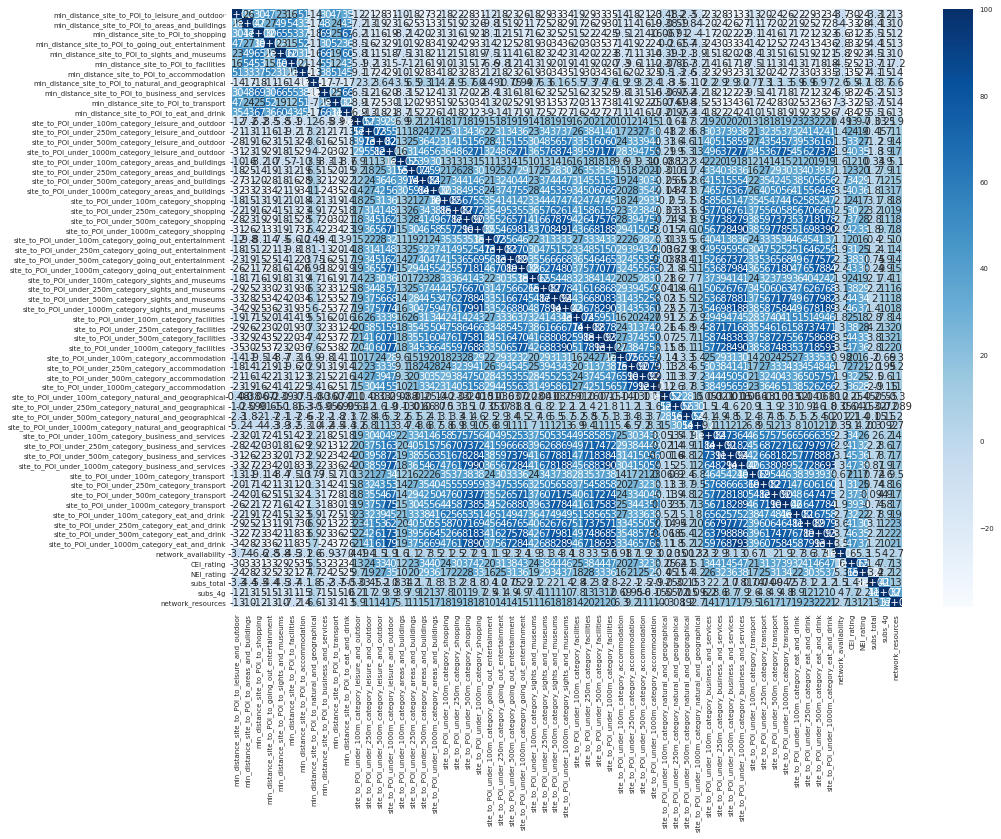

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 11))

import seaborn as sb
corr = df_all_feature.corr()*100
sb.heatmap(corr, cmap="Blues", annot=True)

sb.set(font_scale=1)

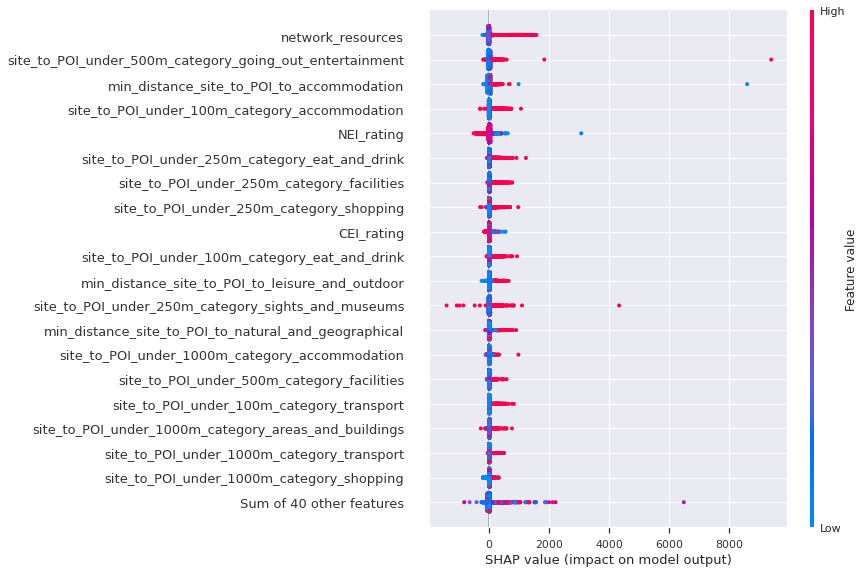

In [10]:
X           = df_all_feature.drop(['subs_4g','subs_total'], axis=1)
y           = df_all_feature[['subs_4g']]
#y           = np.y['subs_4g']
model       = xgb.XGBRegressor().fit(X, y)
explainer   = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=20)

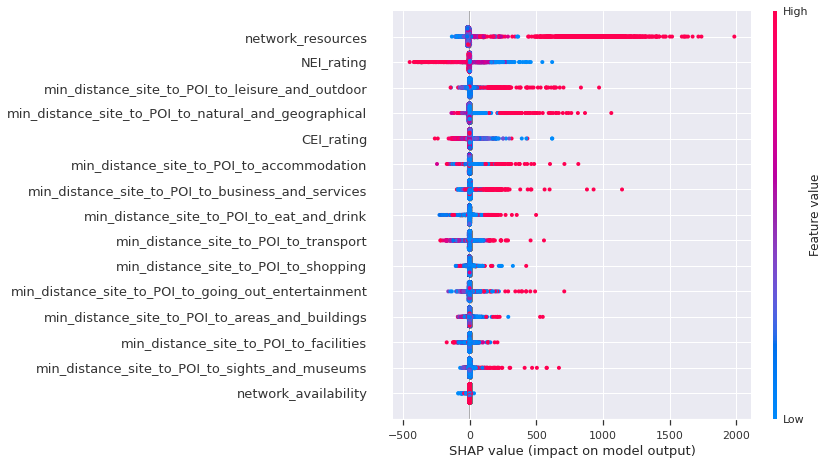

In [11]:
X           = df_dist.drop(['subs_4g','subs_total'], axis=1)
y           = df_dist[['subs_4g']]
#y           = np.y['subs_4g']
model       = xgb.XGBRegressor().fit(X, y)
explainer   = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=20)

invalid value encountered in greater
invalid value encountered in less


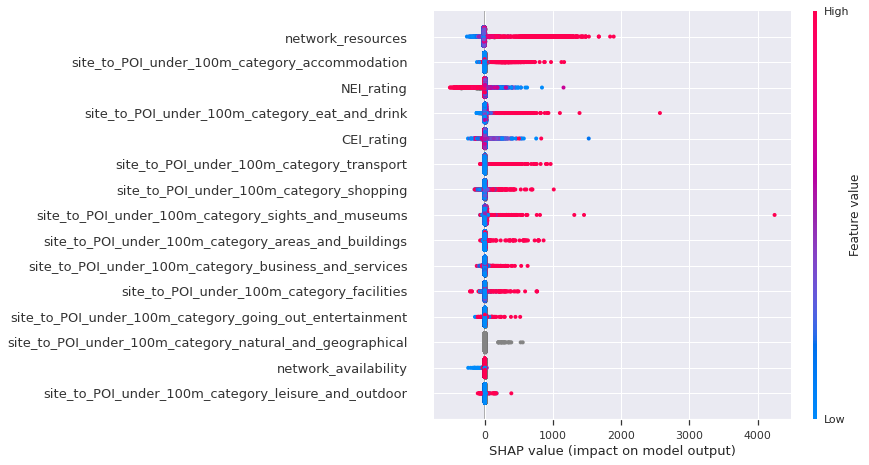

In [12]:
X           = df_range100.drop(['subs_4g','subs_total'], axis=1)
y           = df_range100[['subs_4g']]
#y           = np.y['subs_4g']
model       = xgb.XGBRegressor().fit(X, y)
explainer   = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=20)

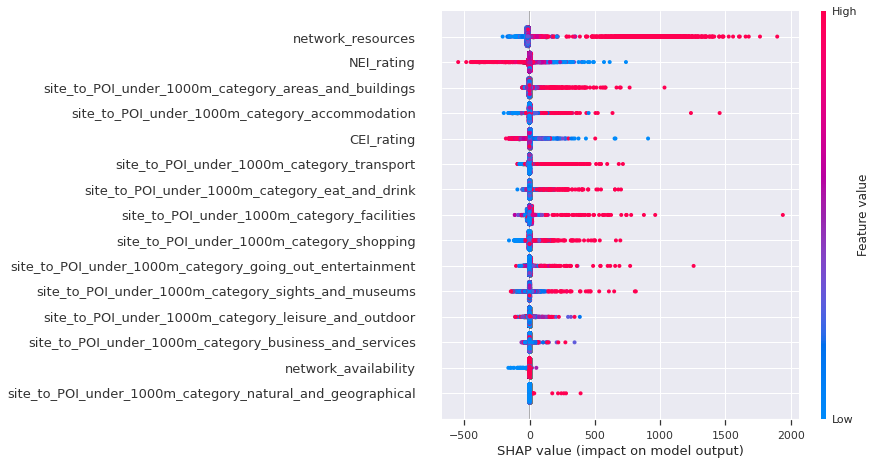

In [16]:
X           = df_range1000.drop(['subs_4g','subs_total'], axis=1)
y           = df_range1000[['subs_4g']]
#y           = np.y['subs_4g']
model       = xgb.XGBRegressor().fit(X, y)
explainer   = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=20)

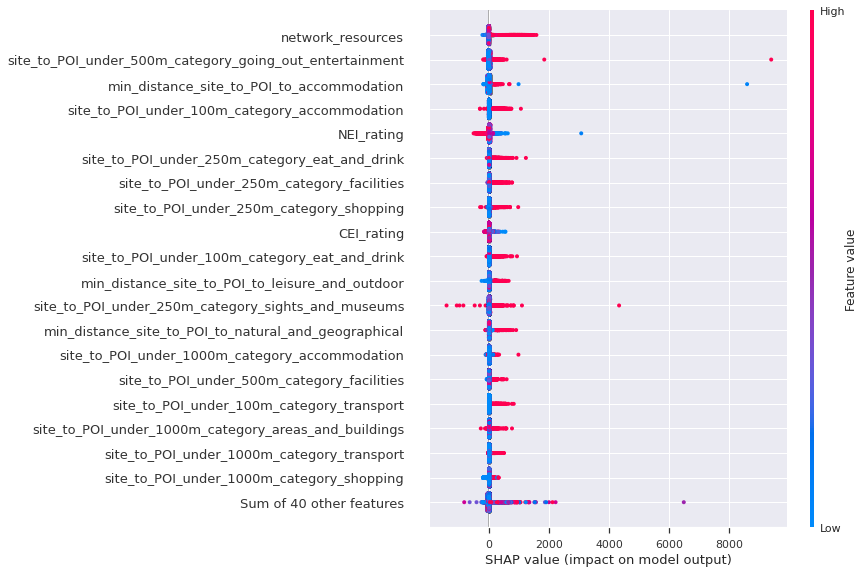

In [20]:
X           = df_all_feature.drop(['subs_4g','subs_total'], axis=1)
y           = df_all_feature[['subs_4g']]
#y           = np.log(y['subs_4g']+1)
model       = xgb.XGBRegressor().fit(X, y)
explainer   = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=20)

In [ ]:
from numpy import absolute
model       = xgb.XGBRegressor().fit(X, y)
cv          = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores      = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
scores      = absolute(scores)
print('Mean r2: %.1f (%.1f)' % (scores.mean(), scores.std()))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor()
model.fit(X, y)

In [ ]:
sklearn.metrics.SCORERS.keys()

In [ ]:
y.median()

In [ ]:
#Trial :

y_pred = model.predict(X)

In [ ]:
#Trial :

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X, y)

_________________________________________________

In [ ]:
model = RandomForestRegressor()
model.fit(X, y)

In [ ]:
model = DecisionTreeRegressor()
model.fit(X, y)

In [52]:
dfX = spark.read.table('dbi.sample_site_for_outlet_v2')
dfX = dfX.toPandas()
dfX.columns

Index(['site_id', 'fea_min_distance_outlet_to_leisure_and_outdoor',
       'fea_min_distance_outlet_to_areas_and_buildings',
       'fea_min_distance_outlet_to_shopping',
       'fea_min_distance_outlet_to_going_out_entertainment',
       'fea_min_distance_outlet_to_sights_and_museums',
       'fea_min_distance_outlet_to_facilities',
       'fea_min_distance_outlet_to_accommodation',
       'fea_min_distance_outlet_to_natural_and_geographical',
       'fea_min_distance_outlet_to_business_and_services',
       'fea_min_distance_outlet_to_transport',
       'fea_min_distance_outlet_to_eat_and_drink',
       'fea_outlet_under_100m_to_leisure_and_outdoor',
       'fea_outlet_under_250m_to_leisure_and_outdoor',
       'fea_outlet_under_500m_to_leisure_and_outdoor',
       'fea_outlet_under_1000m_to_leisure_and_outdoor',
       'fea_outlet_under_100m_to_areas_and_buildings',
       'fea_outlet_under_250m_to_areas_and_buildings',
       'fea_outlet_under_500m_to_areas_and_buildings',
       '

In [56]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

df = spark.sql("""select 
                        b.site_id
                        sum(b.subs_4g) as subs_4g,
                        sum(b.fea_outlet_under_100m_to_leisure_and_outdoor) fea_outlet_under_100m_to_leisure_and_outdoor,
                        sum(b.fea_outlet_under_100m_to_areas_and_buildings) fea_outlet_under_100m_to_areas_and_buildings,
                        sum(b.fea_outlet_under_100m_to_shopping) fea_outlet_under_100m_to_shopping,
                        sum(b.fea_outlet_under_100m_to_going_out_entertainment) fea_outlet_under_100m_to_going_out_entertainment,
                        sum(b.fea_outlet_under_100m_to_sights_and_museums) fea_outlet_under_100m_to_sights_and_museums,
                        sum(b.fea_outlet_under_100m_to_facilities) fea_outlet_under_100m_to_facilities,
                        sum(b.fea_outlet_under_100m_to_accommodation) fea_outlet_under_100m_to_accommodation,
                        sum(b.fea_outlet_under_100m_to_natural_and_geographical) fea_outlet_under_100m_to_natural_and_geographical,
                        sum(b.fea_outlet_under_100m_to_business_and_services) fea_outlet_under_100m_to_business_and_services,
                        sum(b.fea_outlet_under_100m_to_transport) fea_outlet_under_100m_to_transport,            
                        sum(b.fea_outlet_under_100m_to_eat_and_drink) fea_outlet_under_100m_to_eat_and_drink
                    from
                        dbi.sample_site_for_outlet b 
                     group by kecamatan
""").toPandas()

ParseException: "\nmismatched input '(' expecting <EOF>(line 3, pos 27)\n\n== SQL ==\nselect \n                        b.site_id\n                        sum(b.subs_4g) as subs_4g,\n---------------------------^^^\n                        sum(b.fea_outlet_under_100m_to_leisure_and_outdoor) fea_outlet_under_100m_to_leisure_and_outdoor,\n                        sum(b.fea_outlet_under_100m_to_areas_and_buildings) fea_outlet_under_100m_to_areas_and_buildings,\n                        sum(b.fea_outlet_under_100m_to_shopping) fea_outlet_under_100m_to_shopping,\n                        sum(b.fea_outlet_under_100m_to_going_out_entertainment) fea_outlet_under_100m_to_going_out_entertainment,\n                        sum(b.fea_outlet_under_100m_to_sights_and_museums) fea_outlet_under_100m_to_sights_and_museums,\n                        sum(b.fea_outlet_under_100m_to_facilities) fea_outlet_under_100m_to_facilities,\n                        sum(b.fea_outlet_under_100m_to_accommodation) fea_outlet_under_100m_to_accommodation,\n                        sum(b.fea_outlet_under_100m_to_natural_and_geographical) fea_outlet_under_100m_to_natural_and_geographical,\n                        sum(b.fea_outlet_under_100m_to_business_and_services) fea_outlet_under_100m_to_business_and_services,\n                        sum(b.fea_outlet_under_100m_to_transport) fea_outlet_under_100m_to_transport,            \n                        sum(b.fea_outlet_under_100m_to_eat_and_drink) fea_outlet_under_100m_to_eat_and_drink\n                    from\n                        dbi.sample_site_for_outlet b \n                     group by kecamatan\n"